In [1]:
import numpy as np
import sonnet as snt
import tensorflow as tf
import copy
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_celeba(data_dir, restricted_degree, label_type, print_ratio=False):
    """Returns CelebA as (train_data, train_labels, test_data, test_labels)

        Shapes are (162770, 64, 64, 3), (162770, 2), (19962, 64, 64, 3), (19962, 10)
        Data is in [0,1] and labels are one-hot

        Arg:
          restricted_degree: only keep the instances with at least d selected attributes
    """
    train_data = np.load(os.path.join(data_dir, 'celeba_train_imgs.npy')).astype('float32') / 255.0
    test_data = np.load(os.path.join(data_dir, 'celeba_test_imgs.npy')).astype('float32') / 255.0

    info_pak = np.load(os.path.join(data_dir, 'celeba_attr.npz'))
    train_idxs = info_pak['train_idxs']
    val_idxs = info_pak['val_idxs']
    test_idxs = info_pak['test_idxs']
    attribute_names = info_pak['attribute_names']
    attributes = info_pak['attributes']
    male_attr_idx = 20

    def get_label(data, idxs):
        def count_indicators(attr):
            important_attributes_idx = [0, 1, 4, 9, 16, 18, 22, 24, 29, 30, 34, 36, 37, 38]
            x = np.array([0] * attr.shape[0])
            for i in important_attributes_idx:
                x = x + attr[:, i]
            return x

        label = attributes[idxs]
        sig = count_indicators(label) >= restricted_degree
        label = label[sig]
        data = data[sig]

        if label_type == 'gender':
            label = 1-label[:, male_attr_idx].reshape([-1, 1])
            label = np.append(label, 1 - label, 1)
        elif label_type == 'subattr':
            # decission_tree_attr_idx = [1, 6, 34, 35, 36]
            # decission_tree_attr_idx = [0, 1, 6, 7, 8, 9, 12, 18, 19, male_attr_idx, 24, 34, 36, 38, 39]
            decission_tree_attr_idx = [i for i in range(label.shape[1])]
            sub_attributes_idx = np.array(decission_tree_attr_idx)
            label = label[:, sub_attributes_idx]
        return data, label

    train_data, train_label = get_label(train_data, train_idxs)
    test_data, test_label = get_label(test_data, test_idxs)

    if print_ratio:
        print('\nCelebA restricted degree: {}'.format(restricted_degree))
        train_ratio = sum(train_label[:, 1]) / train_label.shape[0]
        test_ratio = sum(test_label[:, 1]) / test_label.shape[0]
        print('Training set - Male: {:.2f}% ({}/{}), Not male: {:.2f}%'.format(train_ratio * 100,
                                                                               sum(train_label[:, 1]),
                                                                               train_label.shape[0],
                                                                               100 - train_ratio * 100))
        print('Testing set - Male: {:.2f}% ({}/{}), Not male: {:.2f}%'.format(test_ratio * 100,
                                                                              sum(test_label[:, 1]),
                                                                              test_label.shape[0],
                                                                              100 - test_ratio * 100))

    return train_data[:2000], train_label[:2000], test_data, test_label

In [3]:
train_data, train_labels, test_data, test_labels = load_celeba(
        'H:\\CodeRange\\CelebA\\npy\\', restricted_degree=0, print_ratio=False, label_type='gender')

_, train_latent_labels, _, test_latent_labels = load_celeba(
    'H:\\CodeRange\\CelebA\\npy\\', restricted_degree=0, print_ratio=False, label_type='subattr')

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
model=tf.saved_model.loader.load(session, [tf.saved_model.tag_constants.SERVING], './saved_model')

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./saved_model\variables\variables


In [5]:
def get_variables(model_meta):
    graph = tf.get_default_graph()
    sig_vars = copy.deepcopy(model_meta.signature_def['serving_default'])
    sig_inputs = sig_vars.inputs
    sig_outputs = sig_vars.outputs
    output = dict()
    for k in sig_inputs.keys():
        print('{:20}, {}'.format(k,sig_inputs[k].name))
        output[k] = graph.get_tensor_by_name(sig_inputs[k].name)
    for k in sig_outputs.keys():
        print('{:20}, {}'.format(k,sig_outputs[k].name))
        output[k] = graph.get_tensor_by_name(sig_outputs[k].name)
    return output

tensors = get_variables(model)

t_x = tensors['x']
t_x_latent = tensors['x_latent']
t_latent_labels = tensors['latent_labels']
t_output = tensors['output']

x                   , data_ph:0
x_latent            , latent_label_ph:0
latent_labels       , vae_1/strided_slice:0
latent_var          , vae_1/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0
output              , vae_1/batch_apply/Reshape_1:0


In [34]:
epoch_size = 32

test_data_len = test_data.shape[0]
epoch_num = test_data_len // epoch_size
# epoch_num = 60
instance_num = epoch_num * epoch_size

latent_labels = []
for i in tqdm(range(epoch_num)):
    epoch_beg = i*epoch_size
    epoch_end = (i+1)*epoch_size
#     print(epoch_beg, epoch_end)
    outputs = session.run([t_output, t_latent_labels], 
                          feed_dict={t_x:test_data[epoch_beg:epoch_end], 
                                     t_x_latent:test_latent_labels[epoch_beg:epoch_end]})
    latent_labels.append(outputs[1])
latent_labels = np.concatenate(latent_labels)>0
correct = latent_labels==(test_latent_labels[:instance_num])
accu = sum(correct)/instance_num

100%|████████████████████████████████████████████████████████████| 623/623 [00:07<00:00, 79.43it/s]


In [35]:
attributes_names = np.load('./gender-classification/data/toy_celeba/celeba_attr.npz')['attribute_names']
for i,ac in enumerate(accu):
    print('{:4}: {:20}, {:.4f}'.format(i, attributes_names[i], ac))

   0: 5_o_Clock_Shadow    , 0.9078
   1: Arched_Eyebrows     , 0.7788
   2: Attractive          , 0.7745
   3: Bags_Under_Eyes     , 0.8271
   4: Bald                , 0.9791
   5: Bangs               , 0.9128
   6: Big_Lips            , 0.7001
   7: Big_Nose            , 0.8176
   8: Black_Hair          , 0.8270
   9: Blond_Hair          , 0.9275
  10: Blurry              , 0.9475
  11: Brown_Hair          , 0.8168
  12: Bushy_Eyebrows      , 0.8916
  13: Chubby              , 0.9491
  14: Double_Chin         , 0.9570
  15: Eyeglasses          , 0.9738
  16: Goatee              , 0.9588
  17: Gray_Hair           , 0.9714
  18: Heavy_Makeup        , 0.8800
  19: High_Cheekbones     , 0.8344
  20: Male                , 0.9480
  21: Mouth_Slightly_Open , 0.8901
  22: Mustache            , 0.9635
  23: Narrow_Eyes         , 0.8603
  24: No_Beard            , 0.9220
  25: Oval_Face           , 0.7284
  26: Pale_Skin           , 0.9669
  27: Pointy_Nose         , 0.7374
  28: Receding_Hairl

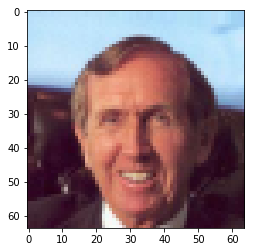

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


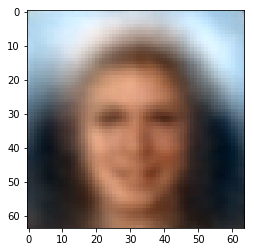

Male: 1
Mustache: 0
No_Beard: 1


In [38]:
# Example

idx = 20

outputs = session.run([t_output, t_latent_labels], feed_dict={t_x:train_data[:32], t_x_latent:train_latent_labels[:32]})

plt.imshow(train_data[idx])
plt.show()

y = outputs[0]
temp = y[0, idx, :]
plt.imshow(temp)
plt.show()

print('Male:', train_latent_labels[idx][20])
print('Mustache:', train_latent_labels[idx][22])
print('No_Beard:', train_latent_labels[idx][24])